In [1]:
# database imports
import re as re
import time
import pandas as pd
import os
import numpy as np

# tokenization imports
import spacy

# frequency counter imports
from collections import Counter
import math

### Precleaning Notes
- some bullet points don't separate words, so I will need to use regex to find key terms like 'Python' and 'Machine Learning.'
- skills and roles are mentioned multiple times throughout a description, so I will need to find a way to limit the skill count increase to one per page.
- remote positions will mostly be empty, but this does not imply on-site. I should try to check the description as well.
- df.title=df.title.str.lower()
- df.title=df.title.str.lstrip()
- df.title=df.title.str.rstrip()

### Resources
- Skills: https://github.com/mikeasilva/data-scientist-skills/blob/master/raw_skills.csv
- Skills: https://www.kaggle.com/code/discdiver/the-most-in-demand-skills-for-data-scientists

In [3]:
df = pd.read_csv('output/linkedin_jobs_testdata.csv')

# EDA

In [4]:
df

,title,company,location,post_date,num_applicants,full_time,size,description,salary
0,Data Scientist,Frontiers,Spain,1 week ago,105 applicants,level,"1,001-5,000 employees · Book and Periodical Pu...",About the job\n \n\n \nWe are on a mi...,NaN
1,Senior Data Analyst (f/m),Axpo Group,"Madrid, Community of Madrid, Spain",14 hours ago,1 applicant,Associate,"5,001-10,000 employees · Utilities",About the job\n \n\n \n ...,NaN
2,Data Architect,Adobe,"Barcelona, Catalonia, Spain",1 week ago,56 applicants,level,"10,001+ employees · Software Development",About the job\n \n\n \nOur Company\n\...,NaN
3,Data scientist,HP,"Sant Cugat del Vallès, Catalonia, Spain",1 week ago,30 applicants,level,"10,001+ employees · IT Services and IT Consulting",About the job\n \n\n \n ...,NaN
4,Data Solution Architect,Bumble,"Barcelona, Catalonia, Spain",3 days ago,25 applicants,Associate,"501-1,000 employees · Technology, Information ...",About the job\n \n\n \nWe strongly en...,NaN
...,...,...,...,...,...,...,...,...,...
69,Principal Marketing Data Scientist,Bandai Namco Mobile,"Barcelona, Catalonia, Spain",2 weeks ago,NaN,level,11-50 employees · Computer Games,About the job\n \n\n \nPAC-MAN to Tek...,NaN
70,Data Platform Engineer (f/m/d),Axpo Group,"Madrid, Community of Madrid, Spain",1 day ago,NaN,Associate,"5,001-10,000 employees · Utilities",About the job\n \n\n \n ...,Full-time
71,Global Integration Services Architect,ADP,"Barcelona, Catalonia, Spain",1 day ago,NaN,Contract,"10,001+ employees · Human Resources Services",About the job\n \n\n \nGlobal Integra...,NaN
72,"Data scientist, Engineer, Physicist, Computer ...",German Aerospace Center (DLR),"Almería, Andalusia, Spain",1 month ago,NaN,level,"5,001-10,000 employees · Research Services",About the job\n \n\n \n ...,Part-time · Entry


In [5]:
# replace null values
df.isnull().sum()

title              0
company            0
location           0
post_date          1
num_applicants    51
full_time          0
size               0
description        0
salary            53
dtype: int64

**Number of applicants** would be nice to compare against the job's **post date** but so many missing values may skew our data. We will evaluate what we have anyway, knowing this.

**Salary** was difficult to find, but it can be merged with Glassdoor later.

In [6]:
# given the inaccuracy and missing value counts of previous data sets, check columns like salary info...
# and all the rest while we're at it
df.title.value_counts()

Data Analyst                                                                  4
Data Scientist, Commercial Systems                                            3
Senior Data Scientist                                                         3
Data Analysis Specialist                                                      3
Data Architect                                                                2
                                                                             ..
Principal Data Scientist                                                      1
DevOps Engineer (E3)                                                          1
Turkish Seller Onboarding, RCCS                                               1
Python Developer Remote                                                       1
Data scientist, Engineer, Physicist, Computer scientist or similar (f/m/x)    1
Name: title, Length: 63, dtype: int64

### Title Column Tasks
- Use regex to group roles together into new "role column". 
- There are many jobs here that do not match data science, which should be removed.

In [7]:
# Define functions for cleaning and categorizing jobs

def clean_titles(title_list):
    """ Clean all dataframe titles by removing cases and spaces """
    clean_title_list = []
    for title in title_list:
        clean_title_list.append(title.str.lower())
        clean_title_list = title.str.lstrip() # FIX
        clean_title_list = title.str.rstrip()
    return clean_title_list

def categorize_role(list_):
    """ categorize all dataframe titles into neater, more uniform groups for later analysis """
    new_list = []
    for item in list_:
        if 'analyst' in item:
            new_list.append('Data Analyst')
        elif 'scientist' or 'science' in item:
            new_list.append('Data Scientist')
        elif 'Engineer' in item:
            new_list.append('Data Engineer')
        elif 'Architect' in item:
            new_list.append('Data Architect')
        elif 'manager' in item:
            new_list.append('Data Manager')
        elif 'business analyst' in item:
            new_list.append('Business Analyst')
        elif 'financ' in item:
            new_list.append('Financial Analyst')
        elif 'marketing analyst' in item:
            new_list.append('Marketing Analyst')
        elif 'data warehouse' in item:
            new_list.append('Data Warehouse'+item)
        else:
            new_list.append('uncategorized')
        
    return new_list

# replace df.titles with new title list using clean_titles(df.title)
df.insert(0, role, categorize_role(df.title)) # FIX: need to self-reference? df = ...

def rm_unrelated_jobs(df):
    """ remove all uncategorized jobs """
    for role in df.title:
        if role == 'uncategorized':
            role.drop() # FIX
    return df

df = (rm_unrelated_jobs(df))

NameError: name 'role' is not defined

In [8]:
df.location.value_counts()

Barcelona, Catalonia, Spain                        39
Madrid, Community of Madrid, Spain                 12
Spain                                               5
Sant Cugat del Vallès, Catalonia, Spain             3
Greater Barcelona Metropolitan Area                 3
Almería, Andalusia, Spain                           2
Alcorcón, Community of Madrid, Spain                1
Seville, Andalusia, Spain                           1
Málaga, Andalusia, Spain                            1
Valencia, Valencian Community, Spain                1
Alicante, Valencian Community, Spain                1
Palma, Balearic Islands, Spain                      1
Zaragoza, Aragon, Spain                             1
European Economic Area                              1
Pamplona, Chartered Community of Navarre, Spain     1
Greater Madrid Metropolitan Area                    1
Name: location, dtype: int64

In [9]:
df.contract_type.value_counts()

AttributeError: 'DataFrame' object has no attribute 'contract_type'

### Full Time Column Task
- Erroneous entries like 'platforms' should be removed.

In [10]:
def rm_unrelated_contracts(df):
    contract_types = ['Associate', 'Full-time', 'Internship', 'Executive', 'Contract', None] # FIX: add all contract types
    for item in df:
        if df.contract_type not in contract_types:
            item.drop() # FIX
    return df

In [11]:
df.company_size.value_counts()

AttributeError: 'DataFrame' object has no attribute 'company_size'

In [12]:
df.salary.value_counts()

Full-time                 8
Full-time · Entry         7
Full-time · Mid-Senior    3
Part-time · Entry         3
Name: salary, dtype: int64

### Salary Column Task
- As I was not able to grab the correct salary information from LinkedIn, and salary data on LinekdIn is so sparse anyway, I will drop this column and scrape Glassdoor for more info.

In [13]:
df.drop(['salary'], axis=1, inplace=True)

# Cleaning & Extraction

As **job description** is the most variable and complex column to grab data from, we will have to perform several actions on it and store the new data in a new column, labeled **'skills.'** Unfortunately, bullet points were not captured from the descriptions so some words are joined with the last word of the previous bullet. We will need to add a space before each capital letter just to solve this issue, and the remove any double-spaces.
- basic cleaning (strip, replace line breaks, etc)
- add a space before each capital letter, then remove any double-spaces
- filter out stop words
- tokenize all words
- print description list's most popular terms and save useful words into new column, 'skills'

In [14]:
# rm columns without descriptions (need each one to be filled so the add-skill function won't skip any empty cols)
df.dropna(subset=['description'], axis=1, inplace=True)

print(df.description[0])

KeyError: ['description']

In [18]:
def rm_special_chars(desc):
    """ remove all special characters from text """
    for char in ['\n','\\','/','–',':',';','...','&','`','*','_','{','}','[',']','(',')','>','#','+','-',',','.com','.','!','¡','?','$','\'','"','@','™']:
        if char in desc:
            desc = desc.replace(char, "")
    return desc



def clean_text_basic(desc_list):
    """ basic text cleaning before tokenization """
    clean_desc_list = []
    for desc in desc_list:
        desc = desc.strip()
        desc = rm_special_chars(desc) # remove special characters
        desc = re.sub(r"([a-z])([A-Z])", r"\1 \2", desc) # add a space before each capital letter to ensure bullet pointed lists are not joined together. # FIX: only do this if the letter before is not cpaital.
        # desc = desc.replace("  ", " ") # remove double-spaces after capital letter fix above FIX: don't need bc line above does this automatically?
        desc = desc.lower()
        clean_desc_list.append(desc)
    return clean_desc_list



def tokenize(desc_list):
    """ remove stop words and tokenize descriptions for skill parsing  """
    
    clean_desc_list = [] # save all descriptions here
    nlp = spacy.load("en_core_web_sm")
    stop = nlp.Defaults.stop_words # all stop words, for removing stop words from descriptions
    
    # REMOVE STOPS
    for desc in desc_list: # loop through each description
        clean_desc = [] # save the given description here, to be added to the clean list after
        for elem in desc.split(" "): # loop through each word in the given description
            if elem not in stop: # skip stopwords
                clean_desc.append(elem) # save words
        stopless_desc = " ".join(clean_desc) # return all words to a string
        
        # TOKENIZE
        tokens = nlp(stopless_desc) # tokenize each review
        lemmatized = []
        for token in tokens:
            lemmatized.append(token.lemma_) # lemmatize each review

        clean_desc_list.append(lemmatized) # add all cleaned descriptions to list
    return clean_desc_list



def clean_text_comprehensive(desc_list):
    """ Clean all descriptions for use in parsing to find skills """

    clean_desc_list = clean_text_basic(desc_list)
    clean_desc_list = tokenize(clean_desc_list)
    
    return clean_desc_list



# DEBUG TEST
fake_list = ["WordWordWWWWWWWord", 'end of bulletNext bullet', 'we Do We want Data AnalystsDO NOT expect anything', ' with an ML Model!']
clean_fake_list = clean_text_comprehensive(fake_list)
print(clean_fake_list)

[['word', 'word', 'wwwwwwword'], ['end', 'bullet', 'bullet'], ['want', 'data', 'analyst', 'expect'], ['ml', 'model']]


### Description Data Task (continued)
Now that we have a list of all tokenized terms in the description list, we ca run a frequency analysis on the aggregate demand for all skills in the data analytics industry.
- In a new 'deflated' list, convert all descriptions to sets in order to prevent skill-value inflation (one job requiring SQL 3 times may make the skill look more valuable than it really is).
- In a new 'rooted' list, take the square root of all terms to give a slightly higher weight to terms which are mentioned more than once, without allowing inflatio nto rise too high.
- Collapse lists into one dimensional arrays.
- Run a frequency analysis on the set list and rooted list to visualize skill frequency. (the inflated frequency still helps visualize what companies care more about, based on how often they mention a skill).

We will also save all skill-related terms into 3 new columns and then run a frequency analysis on each individual job.

Also, I was surprised to find so many emoji in LinkedIn job descriptions. It would be interesting to run an analysis on the most popular emoji on LinkedIn!

In [19]:
# DEBUG
d1 = {'key1':1}
d1.update({'key2':2})
d1

{'key1': 1, 'key2': 2}

In [26]:
def analyze_overall_frequency(desc_list):
    """ parse through description for all relevant skills  """
    
    # TOKENIZE DESCRIPTIONS (store into 2d array)
    clean_desc_list = clean_text_comprehensive(desc_list)
    
    # CONVERT DESCRIPTIONS to ROOTED LIST, collapsing 2d array into 1d
    sqrt_desc_dict = {} # save w sqrt, to give weight to skills mentioned more than once
    for desc in clean_desc_list:
        counted_desc = Counter(desc)
        #print(counted_desc)
        for k, v in counted_desc.items():
            #print(k, v)
            if k in sqrt_desc_dict.keys():
                sqrt_desc_dict[k]+=float(format(math.sqrt(v), ".2f"))
            else:
                sqrt_desc_dict.update({k: float(format(math.sqrt(v), ".2f"))}) # collapse 2d array into 1d, keeping the sqrt of all mentions of terms
            #print({k: format(math.sqrt(v), ".2f")})

    # CONVERT DESCRIPTIONS to DEFLATED LIST, collapsing 2d array into 1d
    deflated_desc_dict = {}
    for desc in clean_desc_list:
        desc = set(desc) # keep only the first mention of each term in a description
        counted_desc = Counter(desc) # count each term (should be 1)
        for k, v in counted_desc.items():
            if k in deflated_desc_dict.keys(): # if term is already present in final dict, add +1
                deflated_desc_dict[k]+=1
            else:
                deflated_desc_dict.update({k:v})
    
    return sqrt_desc_dict, deflated_desc_dict

sqrt_desc_dict, deflated_desc_dict = analyze_overall_frequency(df.description)

# Show the difference between weighted and non-weighted values in overall summary.
print('value to learn Python, weighted:', sqrt_desc_dict['python'])
print('value to learn Python, unweighted:', deflated_desc_dict['python'])

value to learn Python, weighted: 44.19
value to learn Python, unweighted: 41


### Word Processing: Weight
The difference between weighted and non-weighted values is just right: terms with more popularity aren't completely equal to their counterparts and they aren't too high that one skill is worlds better than any others. It is reasonable to keep the square-root-weighted score for comparison between other similarly valuable skills. The marginal difference will decide the final rank of skills to learn for a new job.

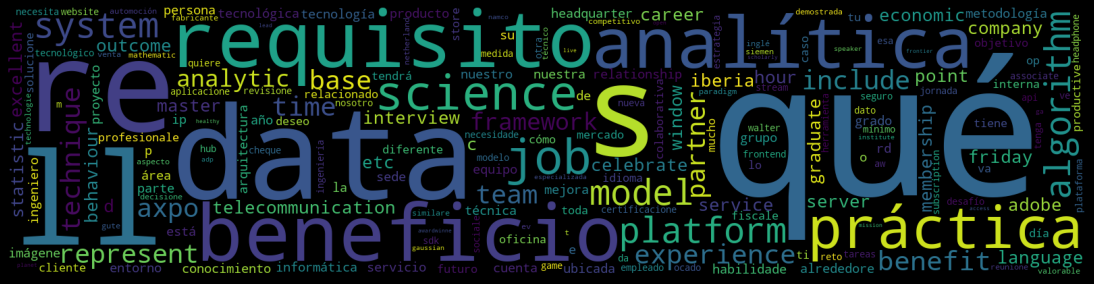

In [21]:
# WORDCLOUD from unfiltered data
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1600,height=400).generate(" ".join(sqrt_desc_dict.keys()))
plt.figure(figsize=(15,10), facecolor="k")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show();

In [25]:
# RELEVANT SKILLS for comparison against description terms
languages_list = ['python','r','sql','spark','hadoop','java','sas','hive','scala','c++','aws','angular','vue.js',
                  'tensorflow','matlab','c','excel','linux','nosql','azure','scikit-learn','spss','pandas',
                  'numpy','pig','d3','keras','javascript','c#','perl','hbase','docker','git','mysql','pyspark',
                  'mongodb','cassandra','pytorch','caffe','node.js','redshift','tableau', 'powerbi', 'power bi',
                  'alteryx','oracle','excel','apache','english','.net','jquery','ruby','postgres','julia','ibm',
                  'scipy','h2o','django','html','css','salesforce','mongo','scikit','node'] # last 3 are alternative names

hard_skills_list = ['data visualization','visualization','data cleaning','cleaning','data mining','mining',
                    'data modeling','modeling','data analysis','analysis','analytics',
                    'machine learning','ml','machine','deep','artificial intelligence','ai','intelligence',
                    'research','simulation','algorithms','automated','predictive','metrics','genetics',
                    'math','linear algebra', 'calculus','statistical analysis','masters','degree','phd',
                    'natural language','language','nlp','neural network','selenium','teradata','cloud',
                    'business intelligence','bi','sales','security','testing','frontend','backend']

soft_skills_list = ['critical thinking','thinking','communication','storytelling','presentation','management',
                    'strategy','process improvement','agile','networking','consulting','leadership']

def parse_for_skills_aggregate(df, desc_list, languages_list, hard_skills_list, soft_skills_list):
    """ Takes in a dataframe and its tokenized terms in order to display an aggregate score for relevant languages and skills in all descriptions """
    # take frequency of all terms
    sqrt_desc_dict, deflated_desc_dict = analyze_overall_frequency(desc_list)
    
    # init new dicts for new columns 
    languages_unranked = {}
    hard_skills_unranked = {}
    soft_skills_unranked = {}    
    
    # FIX: TURN THIS SECTION INTO A FUNCTION
    # FIX: must append these new columns to each job in old df. Can't take skills on their own.
    
    # add all relevant terms to new lists
    for k, v in sqrt_desc_dict.items():
        if k in languages_list:
            languages_unranked.update({k:v})
        elif k in hard_skills_list:
            hard_skills_unranked.update({k:v})
        elif k in soft_skills_list:
            soft_skills_unranked.update({k:v})
    
    # SORT lists
    languages_ranked = dict(sorted(languages_unranked.items(), key=lambda item: item[1]))
    hard_skills_ranked = dict(sorted(hard_skills_unranked.items(), key=lambda item: item[1]))
    soft_skills_ranked = dict(sorted(soft_skills_unranked.items(), key=lambda item: item[1]))
    
    # DEBUG
    print(f'Total weighted popularity of {len(languages_ranked)} lanugages:', '\n', languages_ranked, '\n')
    print(f'Total weighted popularity of {len(hard_skills_ranked)} hard skills:', '\n', hard_skills_ranked, '\n')
    print(f'Total weighted popularity of {len(soft_skills_ranked)} soft skills:', '\n', soft_skills_ranked, '\n')
    
    return

parse_for_skills_aggregate(df, df.description, languages_list, hard_skills_list, soft_skills_list)

Weighted popularity of 35 lanugages: 
 {'perl': 1.0, 'django': 1.0, 'alteryx': 1.0, 'javascript': 1.0, 'mongo': 1.0, 'html': 1.0, 'css': 1.0, 'sas': 1.0, 'keras': 1.0, 'ruby': 1.0, 'node': 1.41, 'pig': 2.0, 'angular': 2.0, 'hive': 3.0, 'scikit': 3.0, 'apache': 3.0, 'numpy': 3.0, 'scala': 3.0, 'hadoop': 4.0, 'redshift': 4.0, 'c': 4.41, 'git': 7.82, 'linux': 8.41, 'oracle': 8.46, 'docker': 9.41, 'excel': 9.82, 'java': 12.23, 'spark': 15.41, 'r': 15.55, 'tableau': 16.55, 'aws': 18.05, 'azure': 21.55, 'sql': 42.239999999999995, 'english': 43.33, 'python': 44.19} 

Weighted popularity of 25 hard skills 
 {'masters': 1.0, 'phd': 1.0, 'math': 1.0, 'simulation': 1.0, 'frontend': 2.0, 'mining': 3.0, 'algorithms': 6.0, 'analytics': 6.41, 'backend': 7.82, 'security': 10.14, 'predictive': 10.41, 'testing': 11.82, 'modeling': 12.41, 'ml': 14.51, 'deep': 14.82, 'intelligence': 15.23, 'ai': 17.89, 'bi': 18.02, 'research': 20.43, 'visualization': 22.01, 'language': 28.51, 'machine': 29.110000000000003

### New Columns from Skills: Languages, Hardk Skills, and Soft Skills
The frequency list (and visual wordcloud) demonstrated a large range of useful skills as well as a lot of garbage data. Now we will parse through the list of tokenized descriptions to find all words matching data-analytics-related launguages, tools, hard skills and soft skills.

In [ ]:
def parse_for_skills_by_row(df, desc_list, skill_list)
    """ Returns a list of values to be added to a new column in a dataframe, from a list of tokenized terms which are checked against a list of relevant skills """    
    # TOKENIZE DESCRIPTIONS (store into 2d array)
    clean_desc_list = clean_text_comprehensive(desc_list)
    
    # add each description's filtered lists to the new columns
    list_of_dicts = {}
    for list_ in list_of_lists:
        temp_dict = {}
        for word in list_:
            if word in languages_list:
                temp = # FIX: save frequency of word in description
                temp = sqrt() # FIX: sqrt of value
                list_of_dicts.update({temp}) # FIX
        # FIX: rank (order by value)
        # FIX: flip (bc rank seems to value lowest first)
    return list_of_dicts

# 3 new columns in dataframe: languages, hard skills, and soft skills
df.insert(3, 'Languages', parse_for_skills_by_row(df, df.description, languages_list))
df.insert(4, 'Hard Skills', parse_for_skills_by_row(df, df.description, hard_skills_list))
df.insert(5, 'Soft Skills', parse_for_skills_by_row(df, df.description, soft_skills_list))

skills_df = parse_for_skills_by_row(df, df.description)
skills_df

In [ ]:
# parse through a tokenized list of descriptions to return all mentions of skills into a new column
df.insert(10, skills, df.description) # FIX: need to self-reference? df =
print(df.skills) # print new list of words

skill_parse(df.description) # parse through description for all relevant skills
df

In [ ]:
# WORDCLOUD from filtered skills
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1600,height=400).generate(" ".join(skills.keys()))
plt.figure(figsize=(15,10), facecolor="k")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('images/wordcloud_skills.png', facecolor='k', bbox_inches='tight')
plt.show();

### BONUS: Emoji on LinkedIn
It seems that the most popular emoji used on LinkedIn is the trademark logo. No surprise there! But why not just use the ascii character?

In [ ]:
# BONUS: MOST POPULAR EMOJI ON LINKEDIN
import emoji
emoji_unranked = {}
for k, v in deflated_desc_dict.items():
    if emoji.is_emoji(k):
        emoji_unranked.update({k:v})

emoji_ranked = dict(sorted(emoji_unranked.items(), key=lambda item: item[1]))
print(emoji_ranked)

In [ ]:
# WORDCLOUD from filtered emoji
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1600,height=400).generate(" ".join(emoji_ranked.keys()))
plt.figure(figsize=(15,10), facecolor="k")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('images/wordcloud_emoji.png', facecolor='k', bbox_inches='tight')
plt.show();

# Export Data to CSV for Visualization

In [ ]:
df.to_csv('linkedin_jobs_cleaned.csv', index = False, encoding='utf-8')
skills_df.to_csv('linkedin_jobs_cleaned.csv', index = False, encoding='utf-8')